In [1]:
##自分のgoogle driveをgoogle colaboratoryに接続
##実行すると、別windowが開き、googleアカウントへのアクセスを許可するか表示される
##許可すると、権限を与えるためのkeyが表示される。コピーし、この下に出てくるkeyを入れるところにペーストし
#Enterキーを押す。
#"Mounted at /content/drive"が表示されれば成功

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


     |████████████████████████████████| 4.1 MB 5.1 MB/s 
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120275 sha256=33efb9a44ebb4227dd412fa31094bb7b7ec82b72a55904af773a3c4e16f33bea
  Stored in directory: /root/.cache/pip/wheels/83/97/6b/e9e0cde099cc40f972b8dd23367308f7705ae06cd6d4714658
Successfully built japanize-matplotlib
TF version: 2.7.0
Hub version: 0.12.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU is available
Using https://tfhub.dev/google/imagenet/mobilenet_v3_small_100_224/feature_vector/5 with input size (224, 224)
Found 111 images belonging to 4 classes.
Found 457 images belonging to 4 classes.
Building model with https://tfhub.dev/google/imagenet/mobilenet_v3_small_100_224/feature_vector/5
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1024

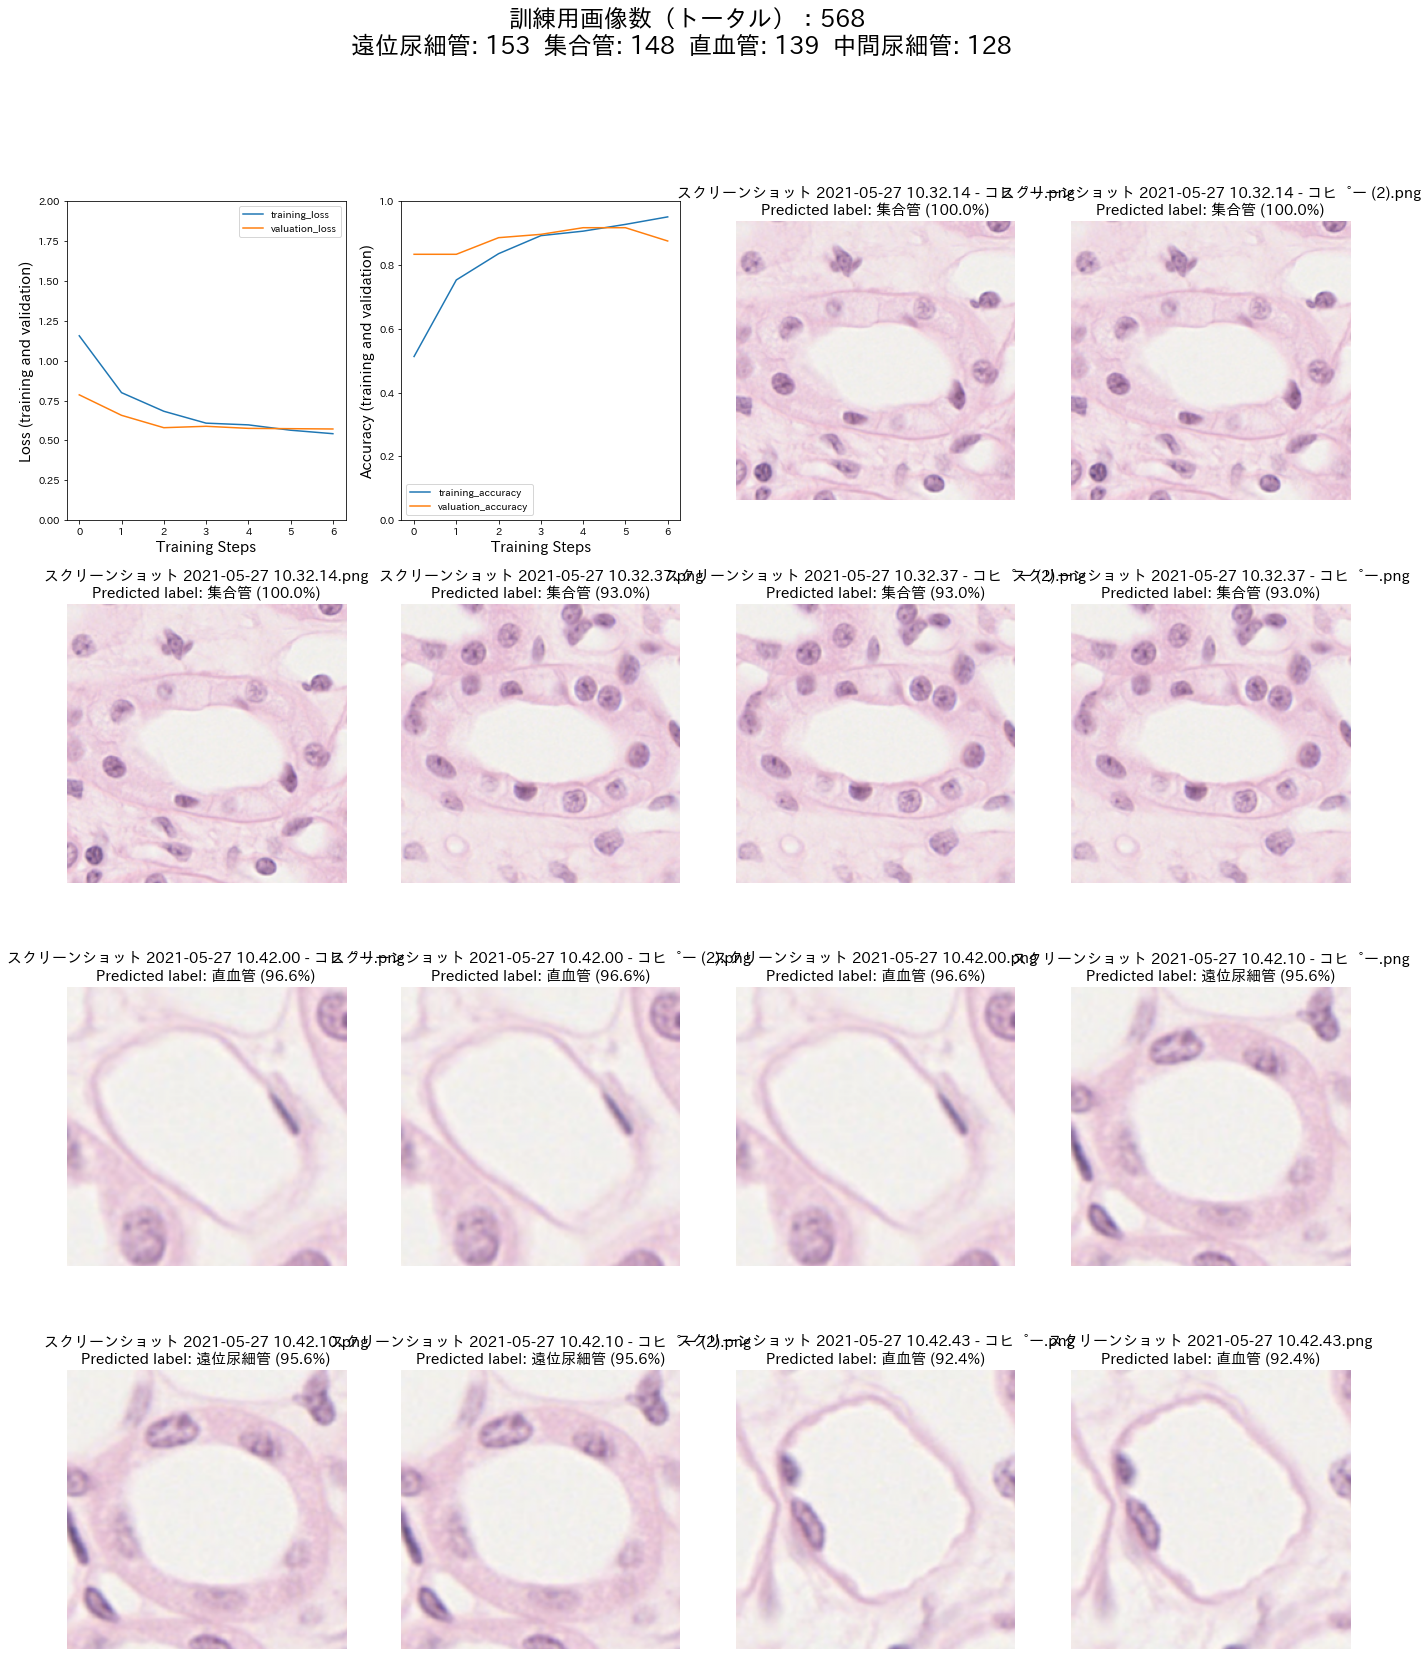

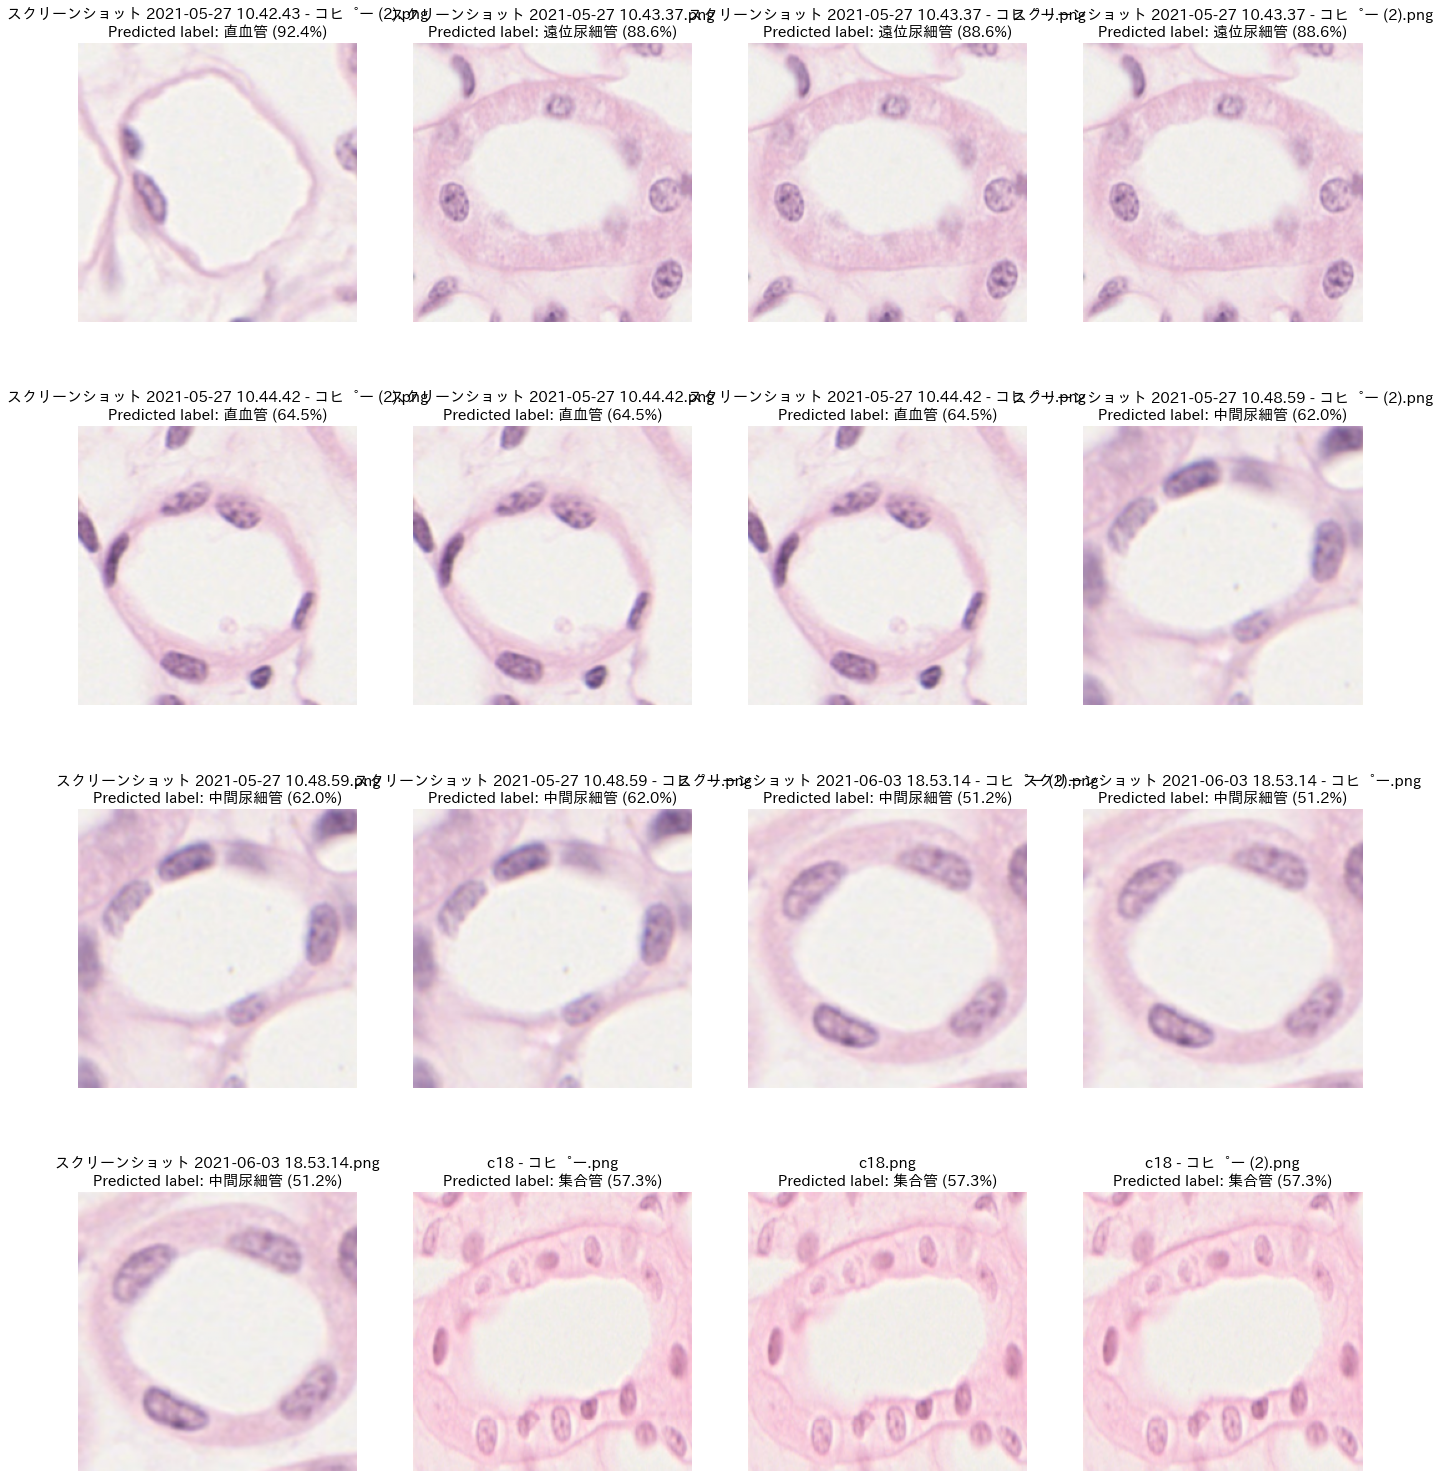

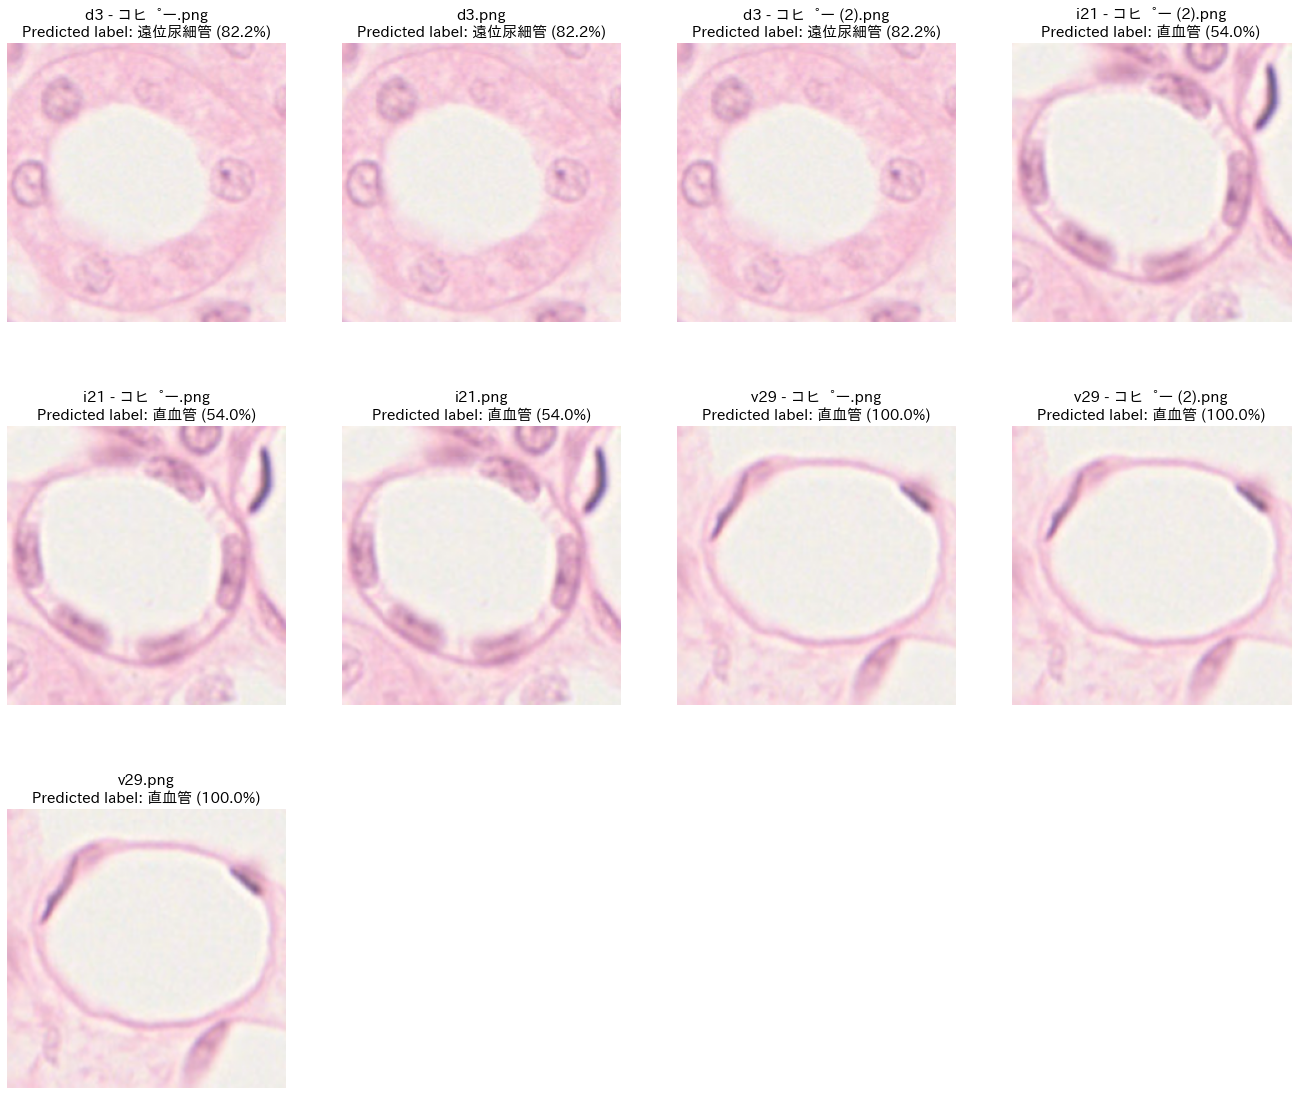

In [2]:
##ライブラリの読み込み
import itertools
import os
import time
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import re
from PIL import Image
from decimal import Decimal, ROUND_HALF_UP

#matplotlib日本語対応バージョン
!pip install japanize-matplotlib
import matplotlib.pyplot as plt
import japanize_matplotlib 

#日本語の濁点が分離してしまう問題に対応
from unicodedata import normalize

###########################################################################################################
#汎用的に使えるようにするためにこの部分に課題ごとに変更が必要になるパラメータを集積する

train_data_dir = '/content/drive/MyDrive/train' #訓練用画像のフォルダdir

test_data_dir = '/content/drive/MyDrive/test2' #作成したモデルによる推論を行いたい画像フォルダdir
Test_images_are_clasified = False #すでに人間が分類したテスト画像に対して推論する場合はTrue、画像に対して推論する場合はFalse

save_dir = '/content/drive/MyDrive/result' #最後に出力するjpegファイルを保存するdir
save_file_name = "prediction.jpg" #出力するjpegファイルの名前　#画像枚数が増えた場合 ***-2.jpg, ***-3.jpgとなる　形式の変更は不可

model_save = False #モデルを保存する場合はTrue、保存しない場合はFalseにする
only_make_model = False #モデルを作成するだけでの場合はTrue、モデルによる推論まで行う場合はFalse

##学習にかかわるパラメータ
epoch_num = 7 #学習のエポック数
#############################################################################################################

##計算時間の計測（スタート）
start_time = time.time()

## NVIDIAのGPUがPCにあれば、設定すればGPUを使って演算させることもできますが、今回の計算量ではGPUは不要です。
print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

#Save directoryが存在しない場合作成する
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

##転移学習に用いる画像分類のモデルの読み込み、設定
module_selection = ("mobilenet_v3_100_224", 224)
handle_base, pixels = module_selection
MODULE_HANDLE = "https://tfhub.dev/google/imagenet/mobilenet_v3_small_100_224/feature_vector/5".format(handle_base)

IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {}".format(MODULE_HANDLE, IMAGE_SIZE))

BATCH_SIZE = 32

scores =[]


# data_dir　ここはtrain_data_dirを使えばよいだけの話なのだが、複数グループに対応するため、あえてこのまま残す
data_dir = train_data_dir

sample_folders_list = os.listdir(data_dir)
sample_folders = [f for f in sample_folders_list if os.path.isdir(os.path.join(data_dir, f))]
label_txt = open(save_dir + '/label.txt', 'w', encoding = "utf-8")
for class_length in range(len(sample_folders)):
    label_txt.write("%s\n" % sample_folders[class_length])
label_txt.close()
total_sample_number = 0
sample_number_str = ""

for o in range(len(sample_folders)):
    q = 0
    sample_image_files = os.listdir(data_dir + '/' + sample_folders[o])
    for p in range(len(sample_image_files)):
        patternStr = '.+\.(jpg|png|PNG|jpeg)'
        pattern = re.compile(patternStr)
        result = pattern.match(sample_image_files[p])
        if result:
            q += 1
            total_sample_number += 1
    sample_number_str += normalize("NFC", sample_folders[o]) + ": " + str(q) + "  "

##ここから先はgoogle colabのものをコピーしてきただけ。
datagen_kwargs = dict(rescale=1. / 255, validation_split=.20)
dataflow_kwargs = dict(target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
                       interpolation="bilinear")

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    **datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
    data_dir, subset="validation", shuffle=False, **dataflow_kwargs)

##augmentation:データの水増し（Trueにすると回転などでデータ数を水増しできる）
do_data_augmentation = False

if do_data_augmentation:
    train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=40,
        horizontal_flip=True,
        width_shift_range=0.2, height_shift_range=0.2,
        shear_range=0.2, zoom_range=0.2,
        **datagen_kwargs)
else:
    train_datagen = valid_datagen
train_generator = train_datagen.flow_from_directory(
    data_dir, subset="training", shuffle=True, **dataflow_kwargs)

print("Building model with", MODULE_HANDLE)

# fine tuningの選択（Trueにすると時間はかかるが、Neural network全体のfine tuningが行われる）
do_fine_tuning = False

model = tf.keras.Sequential([
    # Explicitly define the input shape so the model can be properly
    # loaded by the TFLiteConverter
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    hub.KerasLayer(MODULE_HANDLE, trainable=do_fine_tuning),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(train_generator.num_classes,
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None,) + IMAGE_SIZE + (3,))

##ここで様々なパラメータを変更することもできる（学習効率lrなど）
model.summary()
model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.005, momentum=0.9),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
    metrics=['accuracy'])
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = valid_generator.samples // valid_generator.batch_size
hist = model.fit(
    train_generator,
    epochs=epoch_num, steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=validation_steps).history

# これはここになくてよい気がするので場所の移動を検討
def get_class_string_from_index(index):
    for class_string, class_index in valid_generator.class_indices.items():
        if class_index == index:
            return class_string

##モデルの保存
if model_save:
    saved_model_path = save_dir + "/model"
    tf.keras.models.save_model(model, saved_model_path)

##モデルの保存のみで終わる場合
if only_make_model:
    if model_save:
        print("model was saved")
    else:
        print("If you would like to predict images, you should change 'only_make_model = False'.")
        
##モデルを使った推論とその出力
else:
    ##推論関数
    def image_prediction(image_file):
        ##推測するために、画像を加工
        image_file = image_file.convert("RGB")
        image_file= image_file.resize((224, 224))
        image_file = np.asarray(image_file)
        image_file = image_file.reshape(224, 224, 3)
        image_file = image_file / 255
        
        # Expand the validation image to (1, 224, 224, 3) before predicting the label
        prediction_scores = model.predict(np.expand_dims(image_file, axis=0))
        predicted_index = np.argmax(prediction_scores)
        
        return prediction_scores, predicted_index, image_file
    
    ##分類済みの場合
    if Test_images_are_clasified:
        folders_list = os.listdir(test_data_dir)
        folders = [f for f in folders_list if os.path.isdir(os.path.join(test_data_dir, f))]
        
        correct = 0
        i = 0
        image_prediction_list = []
        
        for l in range(len(folders)):
            image_files = os.listdir(test_data_dir + '/' + folders[l])
            for m in range(len(image_files)):
                patternStr = '.+\.(jpg|png|PNG|jpeg)'
                pattern = re.compile(patternStr)
                result = pattern.match(image_files[m])
                if result:
                    image = Image.open(test_data_dir + '/' + folders[l] + "/" + image_files[m])
                    image_prediction_list.append([folders[l], image_files[m]])
                    prediction_result = image_prediction(image)
                    for n in range(3):
                        image_prediction_list[i].append(prediction_result[n])
                    
                    # print(prediction_scores)
                    total_score = 0
                    predicted_scores = prediction_result[0][0]
                    for o in range(len(predicted_scores)):
                        if predicted_scores[o] > 0:
                            total_score += predicted_scores[o]
                            predicted_percentage = Decimal(max(predicted_scores) / total_score * 100).quantize(Decimal('0.0'), rounding=ROUND_HALF_UP)
                    image_prediction_list[i].append(predicted_percentage)
                    
                    predicted_label = normalize("NFC", get_class_string_from_index(image_prediction_list[i][3]))
                    folder_name = normalize("NFC", folders[l])
                    
                    image_prediction_list[i].append(predicted_label)
                    image_prediction_list[i][0] = folder_name

                    if predicted_label == folder_name:
                        image_prediction_list[i].append("red")
                        correct += 1
                    else:
                        image_prediction_list[i].append("blue")
                    
                    i+=1
                    
 #image_prediction_listは[フォルダ名、画像ファイル名、prediction_score,predicted_index,
 #                         image_file, predicted_percentage, predicted_label, output_color]
                    
        x, y = next(valid_generator) 
        # 予測結果を表示させるための図の作成
        plt.figure(figsize=(23, 27))
        
        ##転移学習の結果(lossとaccuracy)をプロット
        plt.subplot(4, 4, 1)  # 図を4x4分割した時の1番目に配置するという意味（以下同じ）
        plt.ylabel("Loss (training and validation)", fontsize=15)
        plt.xlabel("Training Steps", fontsize=15)
        plt.ylim([0, 2])
        plt.plot(hist["loss"], label="training_loss")
        
        ##データ数が少なくvalidationできなかった時のエラー回避
        try:
            plt.plot(hist["val_loss"], label="valuation_loss")
        except:
            print("The number of image files were not enough to valuation")
        
        plt.legend()
        plt.subplot(4, 4, 2)
        plt.ylabel("Accuracy (training and validation)", fontsize=15)
        plt.xlabel("Training Steps", fontsize=15)
        plt.ylim([0, 1])
        plt.plot(hist["accuracy"], label="training_accuracy")
        ##データ数が少なくvalidationできなかった時のエラー回避
        try:
            plt.plot(hist["val_accuracy"], label="valuation_accuracy")
        except:
            print("")
        plt.legend()
        
        # 正答率と画像枚数をタイトルとして表示
        plt.suptitle(
            "正答率 = " + str(correct) + "/" + str(i) + " (" + str(
                Decimal(correct / i *100).quantize(Decimal('0.0'), rounding=ROUND_HALF_UP)) + "%)"
            + "\n画像数（トータル）：" + str(total_sample_number) + "\n" + sample_number_str,
            fontsize=24)
       
        for p in range(14):
            if p == i:
                break
            else:
                plt.subplot(4, 4, p + 3)
                plt.imshow(image_prediction_list[p][4])
                plt.axis('off')

                # 画像の上に、教員のアノテーションラベルとAIの予測ラベルを表示
                # アノテーションと予測ラベルが合致する場合、赤色で、間違っている場合は青色で表示する
                # 日本語の濁点が分離してしまう問題にも対応
                plt.title(
                    "Annotated label:" + image_prediction_list[p][0] + "\nPredicted label: " + image_prediction_list[p][6]
                    + " (" + str(image_prediction_list[p][5]) + "%)", fontsize=15, color= image_prediction_list[p][7])
        #jpegで保存
        plt.savefig(save_dir + "/" + save_file_name)

        
        
        #２枚目以降のプロット
        additional_page = 1
        jpg_index = save_file_name.find(".jpg")
        
        while (i-14-(additional_page-1)*16) > 1:
            plt.figure(figsize=(23, 27))
            for p in range(16):
                actual_i = p+14+16*(additional_page-1)
                if actual_i == i:
                    break
                else:
                    plt.subplot(4, 4, p+1)
                    plt.imshow(image_prediction_list[actual_i][4])
                    plt.axis('off')

                    # 画像の上に、教員のアノテーションラベルとAIの予測ラベルを表示
                    # アノテーションと予測ラベルが合致する場合、赤色で、間違っている場合は青色で表示する
                    # 日本語の濁点が分離してしまう問題にも対応
                    plt.title(
                        "Annotated label:" + image_prediction_list[actual_i][0] + "\nPredicted label: " + image_prediction_list[actual_i][6]
                        + " (" + str(image_prediction_list[actual_i][5]) + "%)", fontsize=15, color= image_prediction_list[actual_i][7])
                
            #jpegで保存
            plt.savefig(save_dir + "/" + save_file_name[:jpg_index] + "-" + str(additional_page+1) + save_file_name[jpg_index:])
            additional_page += 1
        
        
        # 点数の保存
        print(" Accuracy: " + str(Decimal(correct / i *100).quantize(Decimal('0.0'), rounding=ROUND_HALF_UP) )+ "% " + str(total_sample_number) + " images")
        elapsed_time = time.time() - start_time
        print ("elapsed_time:{0}".format(elapsed_time) + "[sec]")
            
    #推論画像が分類されていない場合    
    else:
        i = 0
        image_prediction_list = []
        image_files = os.listdir(test_data_dir)
        for m in range(len(image_files)):
            patternStr = '.+\.(jpg|jpeg|png|PNG)'
            pattern = re.compile(patternStr)
            result = pattern.match(image_files[m])
            
            if result:
                image = Image.open(test_data_dir + "/" + image_files[m])
                image_prediction_list.append(["null", image_files[m]])
                prediction_result = image_prediction(image)
                for n in range(3):
                    image_prediction_list[i].append(prediction_result[n])
                    
                total_score = 0
                predicted_scores = prediction_result[0][0]
                for o in range(len(predicted_scores)):
                    if predicted_scores[o] > 0:
                       total_score += predicted_scores[o]
                       predicted_percentage = Decimal(max(predicted_scores) / total_score * 100).quantize(Decimal('0.0'), rounding=ROUND_HALF_UP)
                image_prediction_list[i].append(predicted_percentage) 
                predicted_label = normalize("NFC", get_class_string_from_index(image_prediction_list[i][3]))
                image_prediction_list[i].append(predicted_label)
                
#image_prediction_listは["null"、画像ファイル名、prediction_score,predicted_index,
#                       image_file, predicted_percentage, predicted_label]
                i+=1
        
        x, y = next(valid_generator) 
        # 予測結果を表示させるための図の作成  
        plt.figure(figsize=(23, 27))
        
        ##転移学習の結果(lossとaccuracy)をプロット
        plt.subplot(4, 4, 1)  # 図を4x4分割した時の1番目に配置するという意味（以下同じ）
        plt.ylabel("Loss (training and validation)", fontsize=15)
        plt.xlabel("Training Steps", fontsize=15)
        plt.ylim([0, 2])
        plt.plot(hist["loss"], label="training_loss")
        
        ##データ数が少なくvalidationできなかった時のエラー回避
        try:
            plt.plot(hist["val_loss"], label="valuation_loss")
        except:
            print("The number of image files were not enough to valuation")
        
        plt.legend()
        plt.subplot(4, 4, 2)
        plt.ylabel("Accuracy (training and validation)", fontsize=15)
        plt.xlabel("Training Steps", fontsize=15)
        plt.ylim([0, 1])
        plt.plot(hist["accuracy"], label="training_accuracy")
        ##データ数が少なくvalidationできなかった時のエラー回避
        try:
            plt.plot(hist["val_accuracy"], label="valuation_accuracy")
        except:
            print("")
        plt.legend()
        
        # 正答率と画像枚数をタイトルとして表示
        plt.suptitle(
            "訓練用画像数（トータル）：" + str(total_sample_number) + "\n" + sample_number_str,
            fontsize=24)
       
        for p in range(14):
            if p == i:
                break
            else:
                plt.subplot(4, 4, p + 3)
                plt.imshow(image_prediction_list[p][4])
                plt.axis('off')
                #　画像の下に画像名を表示
                #plt.set_xlabel(image_prediction_list[p][1])

                # 画像の上に、AIの予測ラベルを表示
                # 日本語の濁点が分離してしまう問題にも対応
                plt.title(
                    image_prediction_list[p][1]
                    + "\nPredicted label: " + image_prediction_list[p][6]
                    + " (" + str(image_prediction_list[p][5]) + "%)", fontsize=15)
        #jpegで保存
        plt.savefig(save_dir + "/" + save_file_name)
        
        #２枚目以降のプロット
        additional_page = 1
        jpg_index = save_file_name.find(".jpg")
        
        while (i-14-(additional_page-1)*16) > 1:
            plt.figure(figsize=(23, 27))
            for p in range(16):
                actual_i = p+14+16*(additional_page-1)
                if actual_i == i:
                    break
                else:
                    plt.subplot(4, 4, p+1)
                    plt.imshow(image_prediction_list[actual_i][4])
                    plt.axis('off')
                    #　画像の下に画像名を表示
                    #plt.set_xlabel(image_prediction_list[p][1])

                    # 画像の上に、AIの予測ラベルを表示
                    # 日本語の濁点が分離してしまう問題にも対応
                    plt.title(
                        image_prediction_list[actual_i][1]
                        + "\nPredicted label: " + image_prediction_list[actual_i][6]
                       + " (" + str(image_prediction_list[actual_i][5]) + "%)", fontsize=15)
                
            #jpegで保存
            plt.savefig(save_dir + "/" + save_file_name[:jpg_index] + "-" + str(additional_page+1) + save_file_name[jpg_index:])
            additional_page += 1


        elapsed_time = time.time() - start_time
        print ("elapsed_time:{0}".format(elapsed_time) + "[sec]")

##Ver 1.0 Trial
##Ver 2.0 出力方式を変更、組織画像からの推論を転移学習によって可能に、Colaboratory用ファイル
##Ver 2.1 出力を若干変更
##Ver 2.2 推測の確率表示を追加、推論のための正答データの読み込みを工夫
##Ver 2.2.1 typoを修正
##Ver 3.0 ipynbから.pyに移植、実行にかかった時間の計測を追加。jpg/png以外のデータは受け付けないように変更
##Ver 3.1 訓練画像の枚数をoutput、正答率を集計、GPUを使えるようにしたが不必要
##        出力のタイトルを日本語に変更、グループ毎に成績をソートできるように修正
##Ver 3.2 変更が必要なパラメータを一か所に集積
##Ver 4.0　モデルの保存を可能に
##Ver 4.1 モデルが呼び出せない原因を修正
##Ver 5.0 大幅に変更
##        i:モデルを作製し保存のみも可能に、ii:推論画像の上限を撤廃、iii:未分類の画像の推論も可能に
